In [131]:
import os
import pandas as pd
import numpy as np
import scipy as sp
import datetime
import seaborn as sns
from matplotlib import pyplot as plt

In [132]:
def extract_folder(folderpath, add_scores=False, downsample=None):
    """
    Extract CSV data from folder and subfolders into a dataframe.

    Args:
      folderpath (str): Path to the folder containing CSV files.
      add_scores (bool, optional): Boolean to add scores.csv to the dataframe. Defaults to False.
      downsample (int, optional): Number of rows to downsample CSVs to. Defaults to None.

    Returns:
      pandas.DataFrame: DataFrame of concatenated CSV data.
    """
    import os
    import pandas as pd
    
    # Dict to store dataframes by condition  
    dfs = {'control': [], 'condition': []}

    try:
        # Handle top-level scores CSV
        if add_scores and 'scores.csv' in os.listdir(folderpath):
            scores_path = os.path.join(folderpath, 'scores.csv')  
            dfs['scores'] = pd.read_csv(scores_path)

        # Get subfolders
        subfolders = [f for f in os.listdir(folderpath) if os.path.isdir(os.path.join(folderpath, f))]

        for subfolder in subfolders:
            subfolderpath = os.path.join(folderpath, subfolder)  

            # Get list of CSV files
            files = os.listdir(subfolderpath)

            for file in files:
                filepath = os.path.join(subfolderpath, file)

                # Extract ID from filename 
                id = file.split('.')[0]

                df = pd.read_csv(filepath)

                # Downsample if needed
                if downsample:
                    df = df.sample(downsample)

                # Add ID column - this is the filename without the extension
                df['id'] = id

                # Add 'condition' column
                df['condition'] = subfolder

                # Convert 'timestamp' and 'date' to datetime
                df['timestamp'] = pd.to_datetime(df['timestamp'])
                df['date'] = pd.to_datetime(df['date'])

                # Append to dict by condition
                if subfolder == 'control':
                    dfs['control'].append(df)
                else:  
                    dfs['condition'].append(df)

    except OSError:
        print(f"Error reading folder: {folderpath}")

    # concatenate dfs for each condition
    dfs['control'] = pd.concat(dfs['control'])
    dfs['condition'] = pd.concat(dfs['condition'])

    # Reset index on the final df
    df = pd.concat([dfs['control'], dfs['condition']]).reset_index(drop=True)

    # add label column
    df['label'] = 0
    df.loc[df['condition'] == 'condition', 'label'] = 1
    
    # remove old 'condition' column
    df.drop('condition', axis=1, inplace=True)

    # Final concat
    return df

In [133]:
extract_folder('../data/depresjon')

,timestamp,date,activity,id,label
0,2003-03-18 15:00:00,2003-03-18,60,control_1,0
1,2003-03-18 15:01:00,2003-03-18,0,control_1,0
2,2003-03-18 15:02:00,2003-03-18,264,control_1,0
3,2003-03-18 15:03:00,2003-03-18,662,control_1,0
4,2003-03-18 15:04:00,2003-03-18,293,control_1,0
...,...,...,...,...,...
1571701,2004-06-10 15:03:00,2004-06-10,0,condition_9,1
1571702,2004-06-10 15:04:00,2004-06-10,0,condition_9,1
1571703,2004-06-10 15:05:00,2004-06-10,449,condition_9,1
1571704,2004-06-10 15:06:00,2004-06-10,0,condition_9,1


In [134]:
df.describe()

,timestamp,activity,label,Year,Hour,Minute
count,1571706,1.571706e+06,1.571706e+06,1.571706e+06,1.571706e+06,1.571706e+06
mean,2003-12-11 11:28:18.007070208,1.795652e+02,3.510300e-01,2.003445e+03,1.150951e+01,2.949255e+01
min,2002-05-24 11:30:00,0.000000e+00,0.000000e+00,2.002000e+03,0.000000e+00,0.000000e+00
25%,2003-04-01 02:07:00,0.000000e+00,0.000000e+00,2.003000e+03,6.000000e+00,1.400000e+01
50%,2003-11-27 19:06:00,4.000000e+00,0.000000e+00,2.003000e+03,1.200000e+01,2.900000e+01
75%,2004-03-08 18:07:00,2.020000e+02,1.000000e+00,2.004000e+03,1.700000e+01,4.400000e+01
max,2006-02-14 13:38:00,8.000000e+03,1.000000e+00,2.006000e+03,2.300000e+01,5.900000e+01
std,NaN,3.597233e+02,4.772925e-01,1.041165e+00,6.914911e+00,1.731840e+01


In [135]:
# this function extracts temporal features from a datetime columns
# and adds them as new columns in the dataframe

def extract_temp_features(df):
    dt_col =  df['timestamp']
    df['Date'] = dt_col.dt.date
    df['Year'] = dt_col.dt.year
    df['Month'] = dt_col.dt.month_name()
    df['Day'] = dt_col.dt.day_name()
    df['Hour'] = dt_col.dt.hour
    df['Minute'] = dt_col.dt.minute
    df['Time'] = dt_col.dt.time
    return(df)

extract_temp_features(df)

,timestamp,activity,id,label,Year,Month,Day,Hour,Minute,Time,Date
date,,,,,,,,,,,
2003-03-18,2003-03-18 15:00:00,60,control_1,0,2003,March,Tuesday,15,0,15:00:00,2003-03-18
2003-03-18,2003-03-18 15:01:00,0,control_1,0,2003,March,Tuesday,15,1,15:01:00,2003-03-18
2003-03-18,2003-03-18 15:02:00,264,control_1,0,2003,March,Tuesday,15,2,15:02:00,2003-03-18
2003-03-18,2003-03-18 15:03:00,662,control_1,0,2003,March,Tuesday,15,3,15:03:00,2003-03-18
2003-03-18,2003-03-18 15:04:00,293,control_1,0,2003,March,Tuesday,15,4,15:04:00,2003-03-18
...,...,...,...,...,...,...,...,...,...,...,...
2004-06-10,2004-06-10 15:03:00,0,condition_9,1,2004,June,Thursday,15,3,15:03:00,2004-06-10
2004-06-10,2004-06-10 15:04:00,0,condition_9,1,2004,June,Thursday,15,4,15:04:00,2004-06-10
2004-06-10,2004-06-10 15:05:00,449,condition_9,1,2004,June,Thursday,15,5,15:05:00,2004-06-10


In [136]:
control = df[df['label'] == 0]

In [137]:
condition = df[df['label'] == 1]

In [138]:
scores = pd.read_csv('data/depresjon/scores.csv')

In [139]:
scores.dtypes

number        object
days           int64
gender         int64
age           object
afftype      float64
melanch      float64
inpatient    float64
edu           object
marriage     float64
work         float64
madrs1       float64
madrs2       float64
dtype: object

In [140]:
males = scores['gender'].value_counts().get(1, 0)

females = scores['gender'].value_counts().get(2, 1)

print(f"The number of males is: {males}")
print(f"The number of females is: {females}")

The number of males is: 30
The number of females is: 25


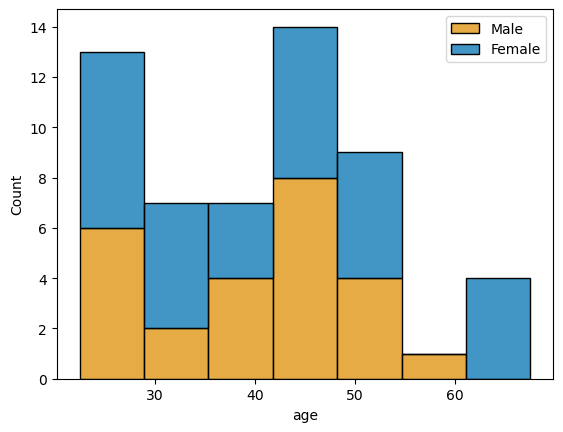

In [141]:
# Convert age ranges to numeric values (midpoints)
scores['age'] = scores['age'].apply(lambda x: int(x.split('-')[0]) + 2.5)  # Assuming midpoint for the age range

# Sort the DataFrame by the 'age' column
scores_sorted = scores.sort_values(by='age')

# Plotting
sns.histplot(data=scores_sorted, x='age', hue='gender', multiple='stack', palette='colorblind')
plt.legend(labels=['Male', 'Female'])
plt.show()

In [143]:
scores['age'].mean()

40.86363636363637

In [149]:
scores['label'] = scores['madrs1'].notna().astype(int)

In [150]:
scores

,number,days,gender,age,afftype,melanch,inpatient,edu,marriage,work,madrs1,madrs2,label
0,condition_1,11,2,37.5,2.0,2.0,2.0,6-10,1.0,2.0,19.0,19.0,1
1,condition_2,18,2,42.5,1.0,2.0,2.0,6-10,2.0,2.0,24.0,11.0,1
2,condition_3,13,1,47.5,2.0,2.0,2.0,6-10,2.0,2.0,24.0,25.0,1
3,condition_4,13,2,27.5,2.0,2.0,2.0,11-15,1.0,1.0,20.0,16.0,1
4,condition_5,13,2,52.5,2.0,2.0,2.0,11-15,2.0,2.0,26.0,26.0,1
5,condition_6,7,1,37.5,2.0,2.0,2.0,6-10,1.0,2.0,18.0,15.0,1
6,condition_7,11,1,22.5,1.0,NaN,2.0,11-15,2.0,1.0,24.0,25.0,1
7,condition_8,5,2,27.5,2.0,NaN,2.0,11-15,1.0,2.0,20.0,16.0,1
8,condition_9,13,2,47.5,1.0,NaN,2.0,6-10,1.0,2.0,26.0,26.0,1
9,condition_10,9,2,47.5,2.0,2.0,2.0,6-10,1.0,2.0,28.0,21.0,1


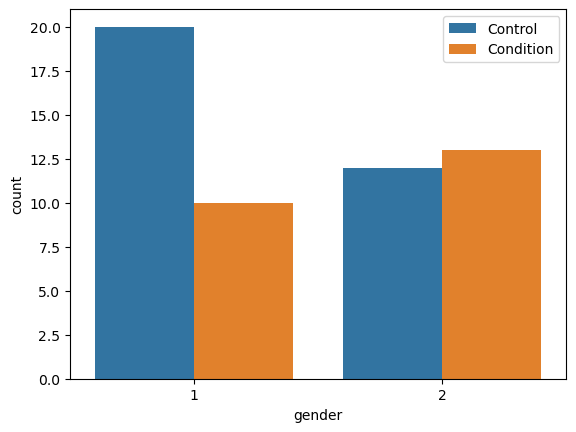

In [153]:
sns.countplot(data=scores, x = 'gender', hue='label')
plt.legend(labels=['Control', 'Condition'])